In [1]:
from pathlib import Path
import sys
sys.path.append('../bitome-kb/')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

    
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from bitome.core import Bitome
from math import log,exp,inf
bitome = Bitome.init_from_file('bitome.pkl')

# try zeroing out all values under cutoff values.
## cutoff = 0.065

In [2]:
features = pd.read_csv('features_multiAvg.csv')
S = pd.read_csv('data/S.csv')
ID = list(features['ID'])

In [3]:
bnumber = list(S['Unnamed: 0'])
imodulons = list(S.columns[1:])

S_dict={}
for r in imodulons:
    S_dict[r]=[]
    for i in range(len(features['ID'])):
        if ID[i] not in bnumber:
            S_dict[r].append(None)
        else:
            x = bnumber.index( ID[i])
            y = imodulons.index( r ) + 1
            S_dict[r].append( S.iloc[x,y] )

In [4]:
S_ex = pd.DataFrame(S_dict)
S_ex = S_ex[ imodulons ]
S_ex.head()

,AllR/AraC/FucR,ArcA-1,ArcA-2,ArgR,AtoC,BW25113,Cbl+CysB,CdaR,CecR,Copper,...,thrA-KO,translation,uncharacterized-1,uncharacterized-2,uncharacterized-3,uncharacterized-4,uncharacterized-5,uncharacterized-6,ydcI-KO,yheO-KO
0,-0.010888,-0.007717,-0.008502,-0.012186,-0.061489,-0.005599,-0.007377,-0.000795,0.004331,0.001845,...,0.479209,0.035685,0.024778,-0.010660,-0.002123,-0.004416,-0.005428,-0.009219,-0.004345,-0.007838
1,-0.011467,0.003042,0.011448,-0.003685,-0.006106,0.006680,-0.043512,0.005107,0.000474,0.007650,...,0.011420,0.040811,0.003324,-0.008424,-0.004415,-0.016126,-0.016476,-0.003497,-0.003583,0.003381
2,-0.008693,0.003944,0.012347,-0.008104,0.000585,0.003245,-0.041283,0.006390,0.004260,0.007109,...,0.011339,0.036244,0.003710,-0.005212,0.000700,-0.011096,-0.006140,-0.003155,-0.008418,0.000129
3,0.001805,0.004035,-0.003115,-0.008237,-0.004015,0.002857,-0.010257,0.002438,-0.002663,0.003988,...,0.011253,0.012013,0.005996,-0.002813,-0.012959,-0.005412,-0.012124,-0.005203,0.001696,-0.002487
4,0.000832,0.003892,0.003911,-0.004145,-0.009006,0.004765,-0.010501,-0.003789,-0.003763,-0.000172,...,0.002125,0.002445,-0.000679,-0.006768,-0.000475,0.003448,0.002953,-0.006742,0.001252,0.001143


In [5]:
S_features = pd.concat([features, S_ex], axis=1)
S_features = S_features.dropna()
S_features = S_features.reset_index()
S_features = S_features.drop(columns=['index'])

In [8]:
X = S_features.iloc[:,1:303].values
X = StandardScaler().fit_transform(X)
targets = {}
for r in imodulons:
    temp = list(S_features[r].values)
    targets[r] = []
    for i in range (len(temp)):
        if temp[i] >= 0.065 or temp[i] <= -0.065:
            targets[r].append( temp[i] )
        else:
            targets[r].append(0)

In [9]:
targets.keys()

dict_keys(['AllR/AraC/FucR', 'ArcA-1', 'ArcA-2', 'ArgR', 'AtoC', 'BW25113', 'Cbl+CysB', 'CdaR', 'CecR', 'Copper', 'CpxR', 'Cra', 'Crp-1', 'Crp-2', 'CsqR', 'CysB', 'DhaR/Mlc', 'EvgA', 'ExuR/FucR', 'FadR', 'FecI', 'FlhDC', 'FliA', 'Fnr', 'Fur-1', 'Fur-2', 'GadEWX', 'GadWX', 'GcvA', 'GlcC', 'GlpR', 'GntR/TyrR', 'His-tRNA', 'Leu/Ile', 'Lrp', 'MalT', 'MetJ', 'Nac', 'NagC/TyrR', 'NarL', 'NikR', 'NtrC+RpoN', 'OxyR', 'PrpR', 'PurR-1', 'PurR-2', 'PuuR', 'Pyruvate', 'RbsR', 'RcsAB', 'RpoH', 'RpoS', 'SoxS', 'SrlR+GutM', 'Thiamine', 'Tryptophan', 'XylR', 'YgbI', 'YiaJ', 'YieP', 'YneJ', 'Zinc', 'crp-KO', 'curli', 'deletion-1', 'deletion-2', 'duplication-1', 'e14-deletion', 'efeU-repair', 'entC-menF-KO', 'fimbriae', 'flu-yeeRS', 'fur-KO', 'gadWX-KO', 'insertion', 'iron-related', 'lipopolysaccharide', 'membrane', 'nitrate-related', 'proVWX', 'purR-KO', 'sgrT', 'thrA-KO', 'translation', 'uncharacterized-1', 'uncharacterized-2', 'uncharacterized-3', 'uncharacterized-4', 'uncharacterized-5', 'uncharacte

# define models to try

In [10]:
y_to_try = {
    'AllR/AraC/FucR':targets['AllR/AraC/FucR'],
    'ArcA-1':targets['ArcA-1'],
    'ArcA-2':targets['ArcA-2'],
    'ArgR':targets['ArgR'],
    'Crp-1':targets['Crp-1'],
    'Crp-2':targets['Crp-2'],
    'DhaR/Mlc':targets['DhaR/Mlc'],
    'CysB': targets['CysB']  
}

In [11]:
models_to_try = {
    'RFR':RandomForestRegressor( random_state=42),
    'ElasticNet':ElasticNet(alpha=1,l1_ratio=0.5,
            max_iter=1000, random_state=42,selection='cyclic'),
    'SVR': SVR(kernel='rbf',degree=3, C=1.0, epsilon=0.1)
}

In [12]:
result_df = pd.DataFrame(
    columns=['model', 'im', 'train_r2', 'test_r2']
)

N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for y_name, y_labels in y_to_try.items():
        print(f'{model_name}: {y_name}')
        
        cv_result = cross_validate(
            model,
            X,
            y= y_labels,
            cv=N_CV,
            scoring='r2',
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'im': [y_name] * N_CV,
                'train_r2': cv_result['train_score'],
                'test_r2': cv_result['test_score']
            }
        )

        result_df = result_df.append(sub_result_df)

RFR
RFR: AllR/AraC/FucR


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   25.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RFR: ArcA-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   44.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RFR: ArcA-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   38.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RFR: ArgR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   16.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RFR: Crp-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   30.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RFR: Crp-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   13.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RFR: DhaR/Mlc


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   22.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RFR: CysB


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   20.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


ElasticNet
ElasticNet: AllR/AraC/FucR
ElasticNet: ArcA-1
ElasticNet: ArcA-2


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ElasticNet: ArgR
ElasticNet: Crp-1
ElasticNet: Crp-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ElasticNet: DhaR/Mlc
ElasticNet: CysB
SVR
SVR: AllR/AraC/FucR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVR: ArcA-1
SVR: ArcA-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVR: ArgR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVR: Crp-1
SVR: Crp-2
SVR: DhaR/Mlc


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVR: CysB


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.3s finished


In [13]:
result_df.to_csv('data/regression_model_selection.csv')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


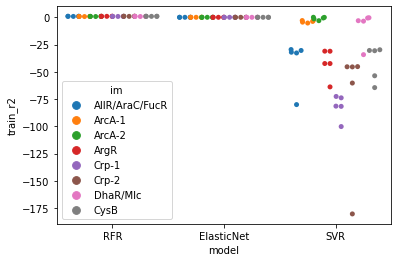

In [14]:
result_df = pd.read_csv('data/regression_model_selection.csv')
_, ax = plt.subplots()
sns.swarmplot(x='model', y='train_r2', data=result_df, hue='im', dodge=True, ax=ax)

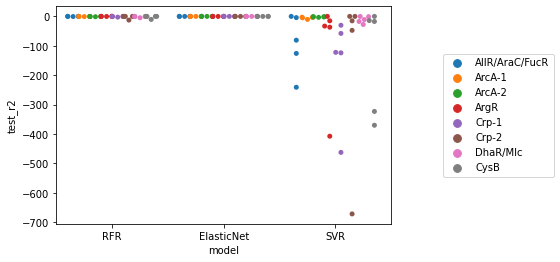

In [15]:
_, ax = plt.subplots()
sns.swarmplot(x='model', y='test_r2', data=result_df, hue='im', dodge=True, ax=ax)
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5))

# hyper param tunning

In [16]:
hyperopt_models = {
    'ElasticNet': {
        'model':ElasticNet(alpha=1,l1_ratio=0.5,
            max_iter=1000, random_state=42),
        'param_dists': {
            'l1_ratio': np.arange(0.0, 1, 20),
             'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
             'selection':['cyclic', 'random'],
            'max_iter':[10,100,1000]          
        }
    },
    'SVR': {
        'model': SVR(kernel='rbf',degree=3, C=1.0, epsilon=0.1),
        'param_dists': {
            'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
            'C': np.arange(0.01, 10, 0.05),
        }
    },
    'RFR': {
        'model': RandomForestRegressor( verbose=1,random_state=42),
        'param_dists': {
            'n_estimators': np.arange(50, 250, 10),
            'max_depth': np.arange(3, 15),
            'min_samples_split': np.arange(0.001, 0.02, 0.001),
            'min_samples_leaf': np.arange(5, 15)
        }
    }
}

In [17]:
hyperopt_RFR = {}

for y_name, y_labels in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['RFR']['model'],
        hyperopt_models['RFR']['param_dists'],
        n_iter=25,
        scoring='r2',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(X,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_RFR[y_name] = hyperopt_results_df

AllR/AraC/FucR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 10.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    8.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ArcA-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.0min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 21.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    7.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ArcA-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 16.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:   15.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ArgR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 11.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   18.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Crp-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 12.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    8.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Crp-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.7min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  8.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    3.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


DhaR/Mlc
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 10.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   15.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CysB
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed: 11.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:   16.4s finished


In [18]:
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_RFR.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)
    
hyperopt_RFR_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)
hyperopt_RFR_df.to_csv('data/hyperopt_RFR.csv')

Text(0.5, 1.0, 'RandomForest_Regression')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


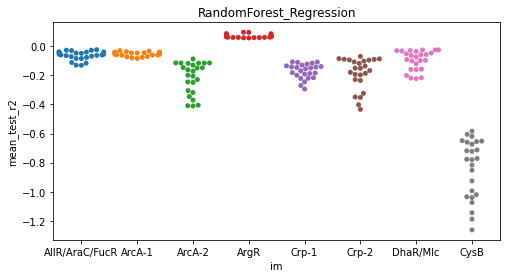

In [19]:
hyperopt_result_df = pd.read_csv( 'data/hyperopt_RFR.csv' , index_col=0)
plt.figure( figsize=(8,4))
sns.swarmplot(x='im', y='mean_test_score', data=hyperopt_result_df)
plt.ylabel('mean_test_r2')
plt.title('RandomForest_Regression')

In [19]:
hyperopt_ElasticNet = {}

for y_name, y_labels in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['ElasticNet']['model'],
        hyperopt_models['ElasticNet']['param_dists'],
        n_iter=25,
        scoring='r2',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit(X,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_ElasticNet[y_name] = hyperopt_results_df

AllR/AraC/FucR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  54 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   16.8s finished
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2808472212606948, tolerance: 5.6995345240050245e-05
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ArcA-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:   13.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   26.5s finished
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11980395185543433, tolerance: 2.430448136889806e-05
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ArcA-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   25.9s finished
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16734497486198266, tolerance: 3.358175157298669e-05
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ArgR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   18.6s finished
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25171383608454234, tolerance: 5.1622970979601615e-05
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Crp-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  54 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   17.5s finished
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07368920959913972, tolerance: 1.4756631717394612e-05
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Crp-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   18.7s finished
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17411200496847515, tolerance: 3.497904866585616e-05
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


DhaR/Mlc
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  66 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   16.7s finished
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19596003991688452, tolerance: 3.928489644914378e-05
  model = cd_fast.enet_coordinate_descent(
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CysB
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  73 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   18.4s finished
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2875334061311481, tolerance: 5.765809526151326e-05
  model = cd_fast.enet_coordinate_descent(


In [20]:
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_ElasticNet.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)
    
hyperopt_ElasticNet_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)
hyperopt_ElasticNet_df.to_csv('data/hyperopt_ElasticNet.csv')

Text(0.5, 1.0, 'ElasticNet')

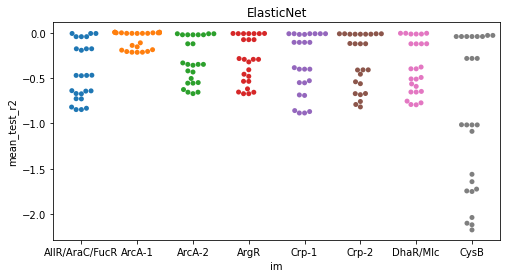

In [21]:
hyperopt_result_df = pd.read_csv( 'data/hyperopt_ElasticNet.csv' , index_col=0)
plt.figure( figsize=(8,4))
sns.swarmplot(x='im', y='mean_test_score', data=hyperopt_result_df)
plt.ylabel('mean_test_r2')
plt.title('ElasticNet')

## after hyperopt, still slightly worse than baseline model

# try to remove all under cutoff 0.065

In [6]:
S_features.head()

,ID,Sigma70,Sigma32,Sigma38,Sigma24,Sigma28,Sigma54,Sigma19,unknown,Sigma70_Prib_score,...,thrA-KO,translation,uncharacterized-1,uncharacterized-2,uncharacterized-3,uncharacterized-4,uncharacterized-5,uncharacterized-6,ydcI-KO,yheO-KO
0,b0002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.762165,...,0.479209,0.035685,0.024778,-0.010660,-0.002123,-0.004416,-0.005428,-0.009219,-0.004345,-0.007838
1,b0003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.762165,...,0.011420,0.040811,0.003324,-0.008424,-0.004415,-0.016126,-0.016476,-0.003497,-0.003583,0.003381
2,b0004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.762165,...,0.011339,0.036244,0.003710,-0.005212,0.000700,-0.011096,-0.006140,-0.003155,-0.008418,0.000129
3,b0008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-4.060455,...,0.011253,0.012013,0.005996,-0.002813,-0.012959,-0.005412,-0.012124,-0.005203,0.001696,-0.002487
4,b0025,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.290289,...,0.002125,0.002445,-0.000679,-0.006768,-0.000475,0.003448,0.002953,-0.006742,0.001252,0.001143


In [7]:
S_features_dict = {}
X_dict={}
target_values = {}
for r in imodulons:
    S_features_dict[r] = S_features[list(S_features.columns[0:303]) + [str(r)]]
    
for r in imodulons:
    temp = list(S_features_dict[r][r].values)
    removal = []
    for i in range (len(temp)):
        if not ( temp[i] >= 0.05 or temp[i] <= -0.05 ):
            removal.append( i )
    
    S_features_dict[r] = S_features_dict[r].drop(removal)
    S_features_dict[r] = S_features_dict[r].reset_index()
    S_features_dict[r] = S_features_dict[r].drop(columns=['index'])

for r in imodulons:
    target_values[r] = list( S_features_dict[r][r] )
    X_dict[r] = S_features_dict[r].iloc[:,1:303].values
    X_dict[r] = StandardScaler().fit_transform( X_dict[r] )

In [8]:
y_to_try = {
    'AllR/AraC/FucR':target_values['AllR/AraC/FucR'],
    'ArcA-1':target_values['ArcA-1'],
    'ArcA-2':target_values['ArcA-2'],
    'ArgR':target_values['ArgR'],
    'Crp-1':target_values['Crp-1'],
    'Crp-2':target_values['Crp-2'],
    'DhaR/Mlc':target_values['DhaR/Mlc'],
    'CysB': target_values['CysB']  
}

models_to_try = {
    'RFR':RandomForestRegressor( random_state=42),
    'ElasticNet':ElasticNet(alpha=1,l1_ratio=0.5,
            max_iter=1000, random_state=42,selection='cyclic'),
    'SVR': SVR(kernel='rbf',degree=3, C=1.0, epsilon=0.1)
}

In [9]:
result_df = pd.DataFrame(
    columns=['model', 'im', 'train_max_error', 'test_max_error']
)

N_CV = 5

for model_name, model in models_to_try.items():
    print(f'{model_name}')
    
    for y_name, y_labels in y_to_try.items():
        print(f'{model_name}: {y_name}')
        
        cv_result = cross_validate(
            model,
            X_dict[y_name],
            y= y_labels,
            cv=N_CV,
            scoring='max_error',
            return_train_score=True,
            verbose=1,
            n_jobs=4
        )

        sub_result_df = pd.DataFrame(
            data={
                'model': [model_name] * N_CV,
                'im': [y_name] * N_CV,
                'train_max_error': cv_result['train_score'],
                'test_max_error': cv_result['test_score']
            }
        )

        result_df = result_df.append(sub_result_df)

RFR
RFR: AllR/AraC/FucR


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RFR: ArcA-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished


RFR: ArcA-2


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RFR: ArgR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RFR: Crp-1


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RFR: Crp-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RFR: DhaR/Mlc


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RFR: CysB


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


ElasticNet
ElasticNet: AllR/AraC/FucR
ElasticNet: ArcA-1
ElasticNet: ArcA-2
ElasticNet: ArgR


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ElasticNet: Crp-1
ElasticNet: Crp-2
ElasticNet: DhaR/Mlc


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ElasticNet: CysB
SVR
SVR: AllR/AraC/FucR


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVR: ArcA-1
SVR: ArcA-2


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


SVR: ArgR
SVR: Crp-1
SVR: Crp-2
SVR: DhaR/Mlc
SVR: CysB


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


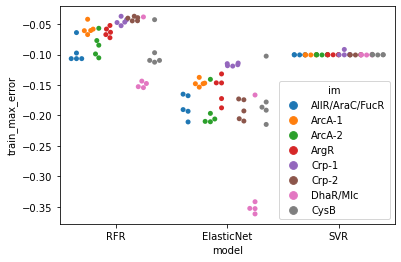

In [10]:
_, ax = plt.subplots()
sns.swarmplot(x='model', y='train_max_error', data=result_df, hue='im', dodge=True, ax=ax)

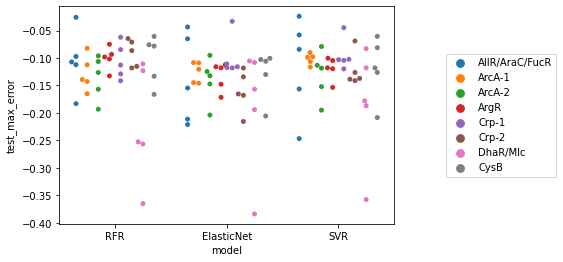

In [11]:
_, ax = plt.subplots()
sns.swarmplot(x='model', y='test_max_error', data=result_df, hue='im', dodge=True, ax=ax)
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.5))

In [12]:
hyperopt_models = {
    'ElasticNet': {
        'model':ElasticNet(alpha=1,l1_ratio=0.5,
            max_iter=1000, random_state=42),
        'param_dists': {
            'l1_ratio': np.arange(0.0, 1, 20),
             'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
             'selection':['cyclic', 'random'],
            'max_iter':[10,100,1000]          
        }
    },
    'SVR': {
        'model': SVR(kernel='rbf',degree=3, C=1.0, epsilon=0.1),
        'param_dists': {
            'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
            'C': np.arange(0.01, 10, 0.05),
        }
    },
    'RFR': {
        'model': RandomForestRegressor( verbose=1,random_state=42),
        'param_dists': {
            'n_estimators': np.arange(50, 250, 10),
            'max_depth': np.arange(3, 15),
            'min_samples_split': np.arange(0.001, 0.02, 0.001),
            'min_samples_leaf': np.arange(5, 15)
        }
    }
}

In [13]:
hyperopt_RFR = {}

for y_name, y_labels in y_to_try.items():
    print(y_name)

    random_search_hyperopt = RandomizedSearchCV(
        hyperopt_models['RFR']['model'],
        hyperopt_models['RFR']['param_dists'],
        n_iter=25,
        scoring='max_error',
        n_jobs=4,
        cv=5,
        verbose=1,
        return_train_score=True
    )

    random_search_hyperopt.fit( X_dict[y_name] ,y_labels )
    
    hyperopt_results_df = pd.DataFrame(random_search_hyperopt.cv_results_).sort_values(
        by='mean_test_score',
        ascending=False
    )
    hyperopt_RFR[y_name] = hyperopt_results_df

AllR/AraC/FucR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   11.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ArcA-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   19.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ArcA-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   21.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ArgR
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   13.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Crp-1
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   15.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Crp-2
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   15.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


DhaR/Mlc
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   31.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CysB
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:   25.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 230 out of 230 | elapsed:    0.3s finished


Text(0.5, 1.0, 'RandomForest_Regression')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


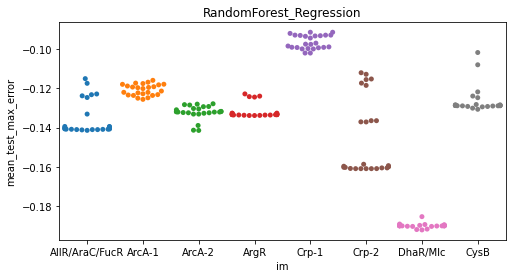

In [14]:
dfs_with_ims = []
for y_name, hyperopt_df in hyperopt_RFR.items():
    hyperopt_df['im'] = [y_name] * hyperopt_df.shape[0]
    dfs_with_ims.append(hyperopt_df)  
hyperopt_RFR_df = pd.concat(dfs_with_ims, axis=0, ignore_index=True)

plt.figure( figsize=(8,4))
sns.swarmplot(x='im', y='mean_test_score', data=hyperopt_RFR_df)
plt.ylabel('mean_test_max_error')
plt.title('RandomForest_Regression')